In [35]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [36]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [37]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [38]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [39]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [40]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [41]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}


Text(0.5, 1.0, '(Label: 7)')

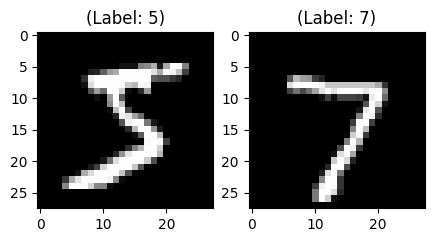

In [42]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [43]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [44]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [45]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [46]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [47]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [48]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)


In [69]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


In [70]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='random_normal')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='random_normal')(up2) # 28 x 28 x 1
    return decoded


In [71]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(learning_rate=0.1))


In [72]:
autoencoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1140 - val_loss: 0.1123
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1120 - val_loss: 0.1123
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1120 - val_loss: 0.1123
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1117 - val_loss: 0.1123
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1122 - val_loss: 0.1123
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1123 - val_loss: 0.1123
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1122 - val_loss: 0.1123
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1120 - val_loss: 0.1123
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1122 - val_loss: 0.1123
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1118 - val_loss: 0.1123
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

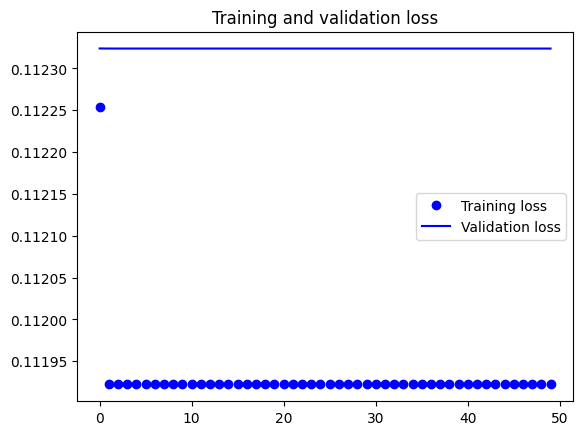

In [54]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [55]:
pred = autoencoder.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [56]:
pred.shape

(10000, 28, 28, 1)

Test Images


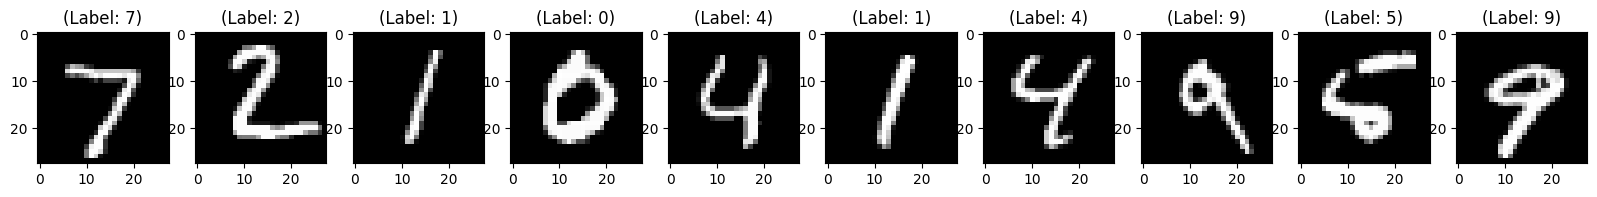

Reconstruction of Test Images


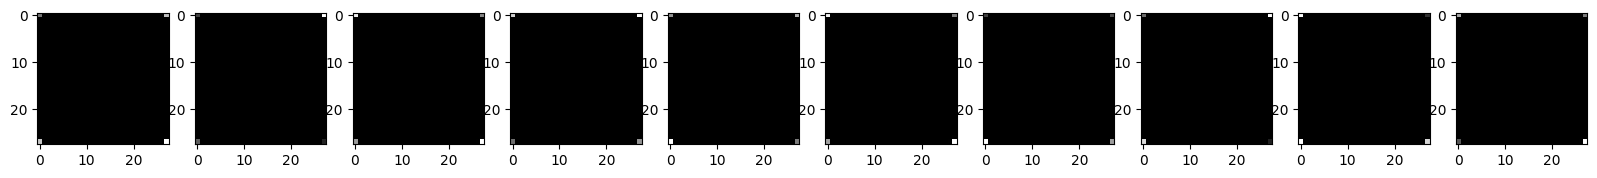

In [57]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [58]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

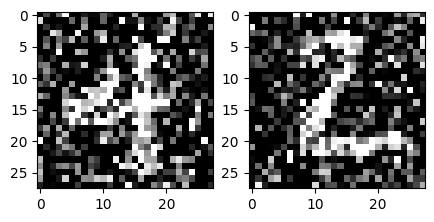

In [59]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [60]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [61]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded


In [62]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [63]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1146 - val_loss: 0.1123
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1118 - val_loss: 0.1123
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1115 - val_loss: 0.1123
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1118 - val_loss: 0.1123
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1120 - val_loss: 0.1123
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1118 - val_loss: 0.1123
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1120 - val_loss: 0.1123
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1118 - val_loss: 0.1123
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1119 - val_loss: 0.1123
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1122 - val_loss: 0.1123
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

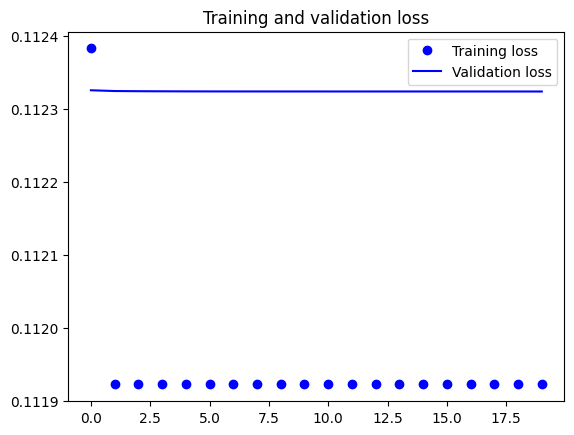

In [64]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [65]:
pred = autoencoder.predict(x_test_noisy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [66]:
print(pred[0])

[[[3.22746299e-03]
  [9.19190061e-05]
  [1.60501422e-05]
  [2.09870245e-06]
  [6.60848798e-07]
  [1.07253051e-07]
  [3.55804204e-08]
  [1.03696722e-08]
  [5.87802207e-09]
  [2.50378607e-09]
  [1.47245860e-09]
  [8.34648184e-10]
  [6.69267142e-10]
  [5.37350830e-10]
  [5.06352738e-10]
  [5.07336895e-10]
  [5.19984500e-10]
  [7.65692787e-10]
  [1.20131138e-09]
  [2.49937226e-09]
  [4.19123758e-09]
  [1.77697554e-08]
  [6.06596799e-08]
  [3.47723926e-07]
  [1.03312948e-06]
  [1.10909987e-05]
  [6.95292620e-05]
  [2.90890690e-03]]

 [[9.05367851e-05]
  [3.61147642e-07]
  [1.83245970e-08]
  [6.24481467e-10]
  [8.34803893e-11]
  [5.46991012e-12]
  [8.16629045e-13]
  [1.05066001e-13]
  [3.77279656e-14]
  [9.86271188e-15]
  [4.01637951e-15]
  [1.55441187e-15]
  [1.04008541e-15]
  [7.13052981e-16]
  [6.40922250e-16]
  [6.08052660e-16]
  [6.56566948e-16]
  [1.16048056e-15]
  [2.51827109e-15]
  [7.79029924e-15]
  [2.01455809e-14]
  [1.77052275e-13]
  [1.46765597e-12]
  [2.29586142e-11]
  [1.64169

Test Images


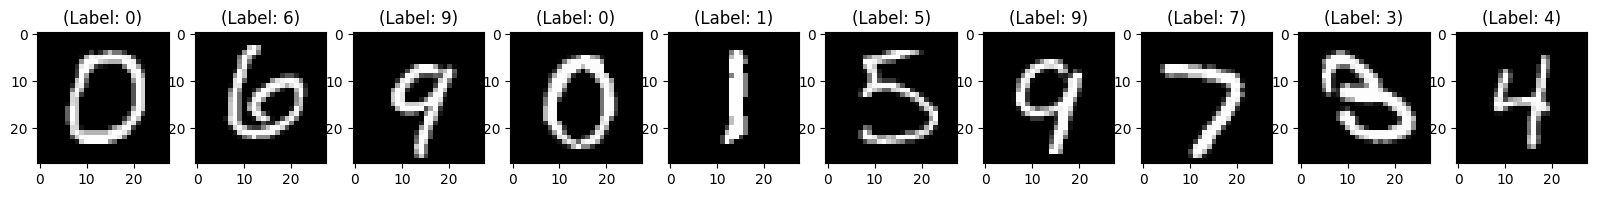

Test Images with Noise


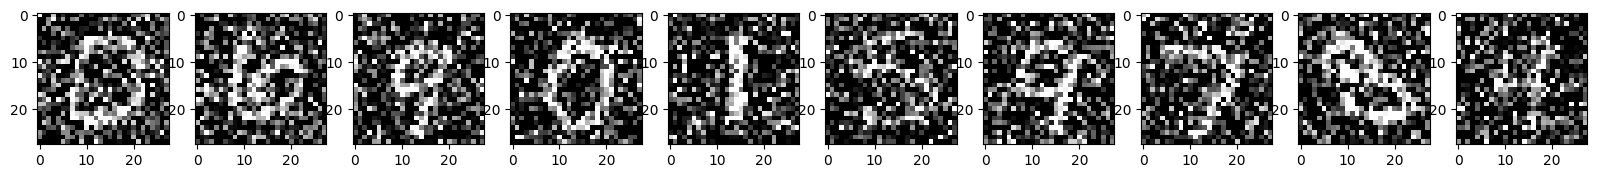

Reconstruction of Noisy Test Images


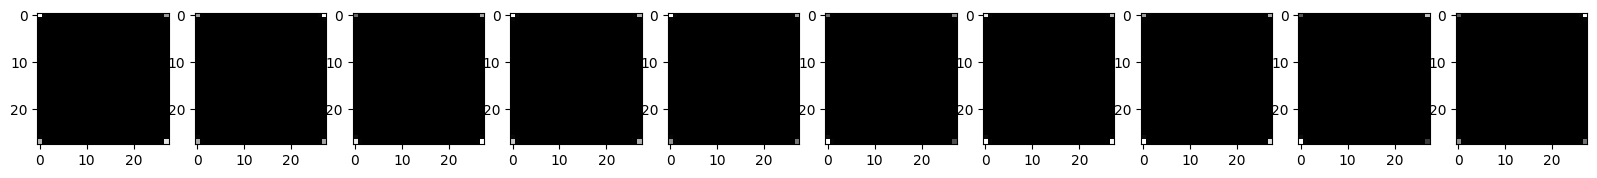

In [67]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()


In [68]:
for layer in autoencoder.layers:
    print(layer.get_config(), layer.get_weights())

{'batch_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'} []
{'name': 'conv2d_18', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[[ 5.63637353e-02,  1.02821812e-02,  5.50400950e-02,
          -8.04825500e-03,  5.51973209e-02, -8.49584490e-02,
           7.55067393e-02, -2.30789259e-02,  2.66775675e-02,
          -1.13241285e-01,  9.91468206e-02,  2.02878900e-02,
          -9.95800